In [1]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import matplotlib.pyplot as plt
from pybt.tools.particles import *
from cpymad.madx import Madx
import requests
import matplotlib.colors as colors

In [2]:
# Beam characteristics
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Initial conditions
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

In [3]:
madx = Madx()
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L, DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence="f61t8_op")

madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, SLICE=5;")
madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")

line = xt.Line.from_madx_sequence(madx.sequence.f61t8_op, install_apertures=False)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.07.11 08:50:55      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: element redefined: mbxhd
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
makethin: style chosen : teapot
makethin: slicing sequence : f61t8_op
Converting sequence "f61t8_op": 83%     


In [4]:
# Defining a reference particle
line.particle_ref = xp.Particles(p0c=24e9, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)

In [5]:
# Create a context (CPU)
import xobjects as xo
context = xo.ContextCpu()

In [6]:
# Build the tracker
import xtrack as xt
line.build_tracker(_context=context)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [7]:
## Build particle object on context
n_part = 5000
n_sigma = 5
x, px = beam_distrib_norm(alfx0, betx0, ex, n_part, n_sigma).T
y, py = beam_distrib_norm(alfy0, bety0, ey, n_part, n_sigma).T
particles = xp.Particles(p0c=24e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=x,
                        px=px,
                        y=y,
                        py=py,
                        zeta=np.random.uniform(0, 0, n_part),
                        delta=np.random.uniform(0, 0, n_part),
                        _context=context)

In [8]:
# Track the particles
line.track(particles, turn_by_turn_monitor="ONE_TURN_EBE")

Text(0.5, 0.98, 'Tracking with xtrack 5000 particles')

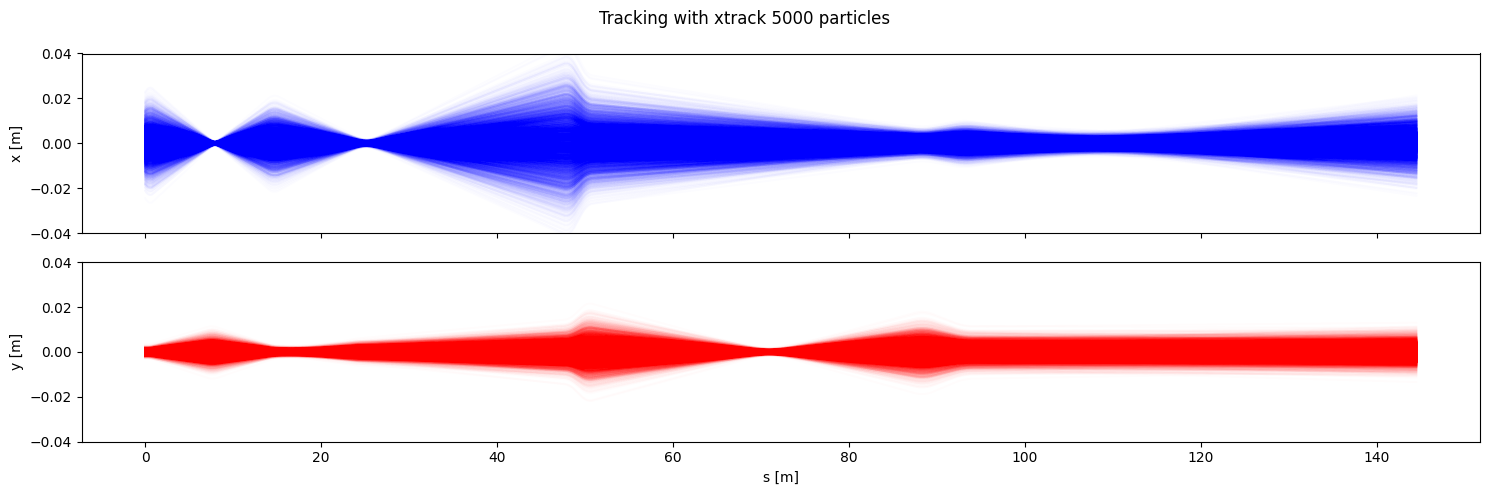

In [15]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(line.record_last_track.s[i], line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(line.record_last_track.s[i], line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

ax[0].set_ylim(-0.04, 0.04)
ax[1].set_ylim(-0.04, 0.04)

fig.suptitle(f'Tracking with xtrack {n_part} particles')

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_13115/935460104.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


Text(0.5, 0.98, 'Tracking with xtrack 5000 particles')

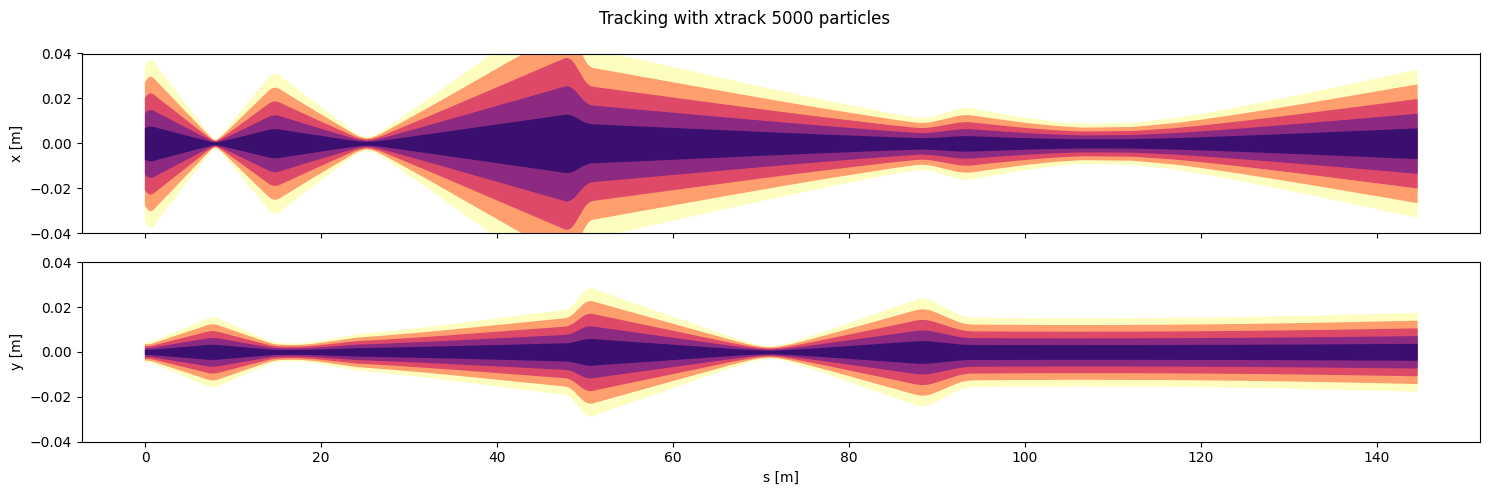

In [16]:
import matplotlib.cm as cm
import numpy as np

fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

s_vals = line.record_last_track.s
x_vals = line.record_last_track.x
y_vals = line.record_last_track.y

# Assume all s-values are the same for each particle
s = s_vals[0]

# Calculate mean and standard deviation across all particles at each point in s
x_mean = np.mean(x_vals, axis=0)
x_std = np.std(x_vals, axis=0)
y_mean = np.mean(y_vals, axis=0)
y_std = np.std(y_vals, axis=0)

# Create colormap
cmap = cm.get_cmap('magma')

# Plot sigma envelopes, from 1 to 5
for i in range(1, 6):
    ax[0].fill_between(s, x_mean-i*x_std, x_mean+i*x_std, color=cmap(i/5), zorder=6-i)
    ax[1].fill_between(s, y_mean-i*y_std, y_mean+i*y_std, color=cmap(i/5), zorder=6-i)

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

ax[0].set_ylim(-0.04, 0.04)
ax[1].set_ylim(-0.04, 0.04)

fig.suptitle(f'Tracking with xtrack {n_part} particles')

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_13115/1124134780.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma')


Text(0.5, 0.98, 'Tracking with xtrack 5000 particles')

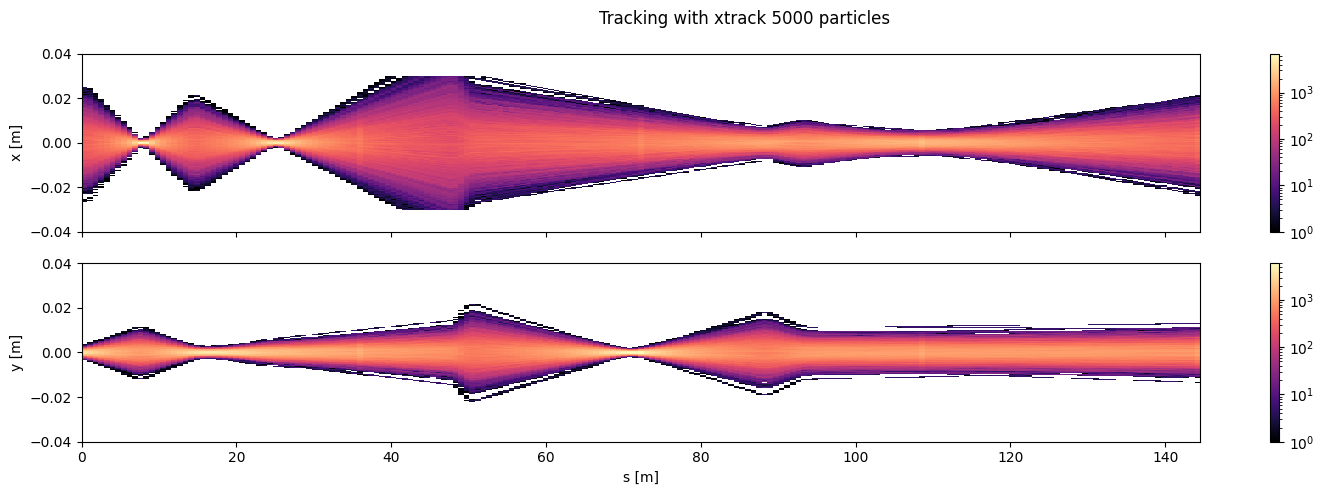

In [18]:
from scipy.interpolate import interp1d

fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

# Create arrays for s, x, and y values
s_values = []
x_values = []
y_values = []

# Flatten the list of arrays to a single array
s_all = np.concatenate(line.record_last_track.s)

# Find the maximum value in the flattened array
s_max = s_all.max()

# Define the new s grid
s_grid = np.linspace(0, s_max, 1000)

# Loop over all particles and append their interpolated x and y values to the arrays
for i in range(len(line.record_last_track.s)):
    s = line.record_last_track.s[i]
    x = line.record_last_track.x[i]
    y = line.record_last_track.y[i]

    # Create interpolation functions for x and y as a function of s
    x_interp = interp1d(s, x, kind='linear', fill_value='extrapolate')
    y_interp = interp1d(s, y, kind='linear', fill_value='extrapolate')

    # Evaluate the interpolation functions on the s grid and append to the arrays
    s_values.extend(s_grid)
    x_values.extend(x_interp(s_grid))
    y_values.extend(y_interp(s_grid))

# Convert the lists to numpy arrays
s_values = np.array(s_values)
x_values = np.array(x_values)
y_values = np.array(y_values)


# Create 2D histograms for x and y
bins = 200
hx, xedges, yedges = np.histogram2d(s_values, x_values, bins=[np.linspace(0, max(s_values), bins), np.linspace(-0.03, 0.03, bins)])
hy, _, _ = np.histogram2d(s_values, y_values, bins=[np.linspace(0, max(s_values), bins), np.linspace(-0.03, 0.03, bins)])

# Define the color scale min and max values
color_min = 1
color_max_x = np.max(hx)
color_max_y = np.max(hy)

# Create the log color normalizer
cmap = plt.cm.get_cmap('magma')
norm_x = colors.LogNorm(vmin=color_min, vmax=color_max_x)
norm_y = colors.LogNorm(vmin=color_min, vmax=color_max_y)

# Draw the density plots
pcm = ax[0].pcolormesh(xedges, yedges, hx.T, cmap=cmap, norm=norm_x)
fig.colorbar(pcm, ax=ax[0])
pcm = ax[1].pcolormesh(xedges, yedges, hy.T, cmap=cmap, norm=norm_y)
fig.colorbar(pcm, ax=ax[1])

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

ax[0].set_ylim(-0.04, 0.04)
ax[1].set_ylim(-0.04, 0.04)

fig.suptitle(f'Tracking with xtrack {n_part} particles')